In [1]:
import scale.olm
import pathlib
import numpy as np
import matplotlib.pyplot as plt

## Local Functions

In [32]:
def reset_reactor_library(burnups=None):
    import shutil
    import os
    import pathlib
    import scale.olm.core

    # Define the base path and other relevant paths
    base_path = '/Users/ww5/olm/collection/w17x17'
    work_path = os.path.join(base_path, '_work')
    arplibs_path = os.path.join(work_path, 'arplibs')
    arpdata_path = os.path.join(work_path, 'arpdata.txt')
    base_arplibs_path = os.path.join(work_path, '_base', 'arplibs')
    base_arpdata_path = os.path.join(work_path, '_base', 'arpdata.txt')

    # Change to the base directory
    os.chdir(base_path)
    
    # Remove the directory and file if they exist
    if os.path.exists(arplibs_path):
        shutil.rmtree(arplibs_path)
    if os.path.exists(arpdata_path):
        os.remove(arpdata_path)
    
    # Copy the base directory and file to the _work directory
    shutil.copytree(base_arplibs_path, arplibs_path)
    shutil.copy(base_arpdata_path, work_path)

    # Initialize ReactorLibrary
    arpdata_full_path = pathlib.Path(arpdata_path)
    name = 'w17x17'
    rl = scale.olm.core.ReactorLibrary(arpdata_full_path, name)

    # Restrict the burnup grid if requested.
    if burnups is not None:
        rl = rl.restrict('times',burnups)
        rl.save()
    return rl

def plot_burnup_grids(burnup_list,labels=None):
    for i,b in enumerate(burnup_list):
        cb=np.asarray(b)/b[-1]
        plt.step(b,cb,label=str(i), where='pre')
        plt.fill_between(b, 0, cb, step='pre', alpha=1.0)

    plt.xlabel('burnup (MWd/MTU)')
    plt.ylabel('cumul. burnup (%)')
    if labels is None:
        plt.legend()
    else:
        plt.legend(labels)
    plt.grid()
    plt.show()

def run_check(case_name, sequence, reactor_library, nuclides=['pu239','pu240']):
    # You need these environment variables corresponding to your setup. This happens after you run
    # olm create config.olm.json to generate the work directory with its files.
    _env={
        "config_file": "/Users/ww5/olm/collection/w17x17/config.olm.json",
        "work_dir": "/Users/ww5/olm/collection/w17x17/_work",
        "scalerte": "/Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte",
        "obiwan": "/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan",
        "nprocs": 8
    }
    _model={
        "name":"w17x17",
        "description":"Library Westinghouse 17x17 design",
        "sources":{
            
        },
        "revision":[
            "1.0"
        ],
        "notes":[
            
        ]
    }
    # Setup the check runner and run the check.
    check = scale.olm.check.LowOrderConsistency(name=case_name+'_'+str(sequence),_env=_env,_model=_model,
                            template='model/origami/system-uox.jt.inp', 
                            nuclide_compare=nuclides)
    info = check.run(reactor_library)
    diff = None
    time = None
    first = True
    for nuclide in nuclides:
        max_diff = np.absolute(np.asarray(info.nuclide_compare[nuclide]['max_diff']))
        min_diff = np.absolute(np.asarray(info.nuclide_compare[nuclide]['min_diff']))
        diff0 = np.maximum(max_diff,min_diff)
        if first:
            first = False
            time = info.nuclide_compare[nuclide]['time']
            diff = diff0
        else:
            diff = np.maximum(diff,diff0)

    return time,diff,info

def get_error_metrics(time,diff):
    reltime = np.asarray(time)/time[-1]
    diff_pct = np.asarray(diff)*100
    i=np.argmax(diff_pct)
    return {
        "reltime": reltime,
        "diff_pct": diff_pct,
        "max_diff_index": i,
        "max_diff_pct": diff_pct[i],
        "max_diff_reltime": reltime[i]
    }

def plot_error_metrics(error_metrics,labels=None):
    for i,e in enumerate(error_metrics):
        plt.plot(e['reltime'],e['diff_pct'],label=str(i))
        plt.fill_between(e['reltime'], 0, e['diff_pct'], alpha=1.0)
        
    plt.xlabel('rel. time (-)')
    plt.ylabel('max rel. error (%)')
    if labels is None:
        plt.legend()
    else:
        plt.legend(labels)
    plt.grid()
    plt.show()
        

## Fine Grid Solution

In [33]:
rl = reset_reactor_library()
fine_burnups = rl.axes_values[-1]
print('Fine grid burnups:', ','.join(['{:.2e}'.format(b) for b in fine_burnups]))

[ 2  1 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 22.21it/s]

Fine grid burnups: 0.00e+00,2.00e+01,5.40e+02,2.02e+03,4.00e+03,6.25e+03,9.00e+03,1.20e+04,1.50e+04,1.80e+04,2.10e+04,2.40e+04,2.70e+04,3.00e+04,3.30e+04,3.60e+04,3.90e+04,4.20e+04,4.50e+04,4.80e+04,5.10e+04,5.40e+04,5.70e+04,6.00e+04,6.30e+04,6.60e+04,6.90e+04,7.20e+04,7.50e+04,7.80e+04,8.10e+04,8.40e+04


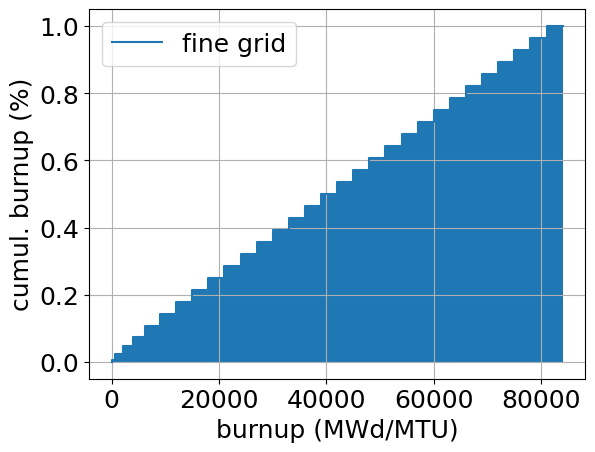

In [34]:
# Burnup grid for original fine grid.
plot_burnup_grids([fine_burnups],labels=['fine grid'])

2024-10-31 09:13:41 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-31 09:13:41 [info     ] Running SCALE                  version=6.3.2
2024-10-31 09:13:41 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/r01_0 && make -j 8
2024-10-31 09:13:41 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-31 09:13:41 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-31 09:13:53 [info     ]                               
2024-10-31 09:13:53 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/r01_0/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-31 09:13:53 [info     ] Running exte

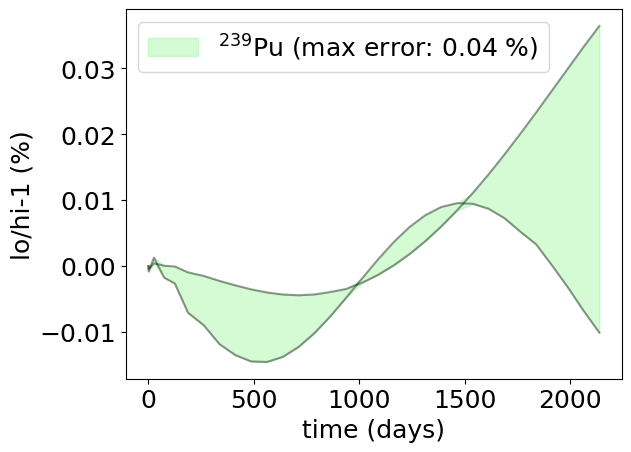

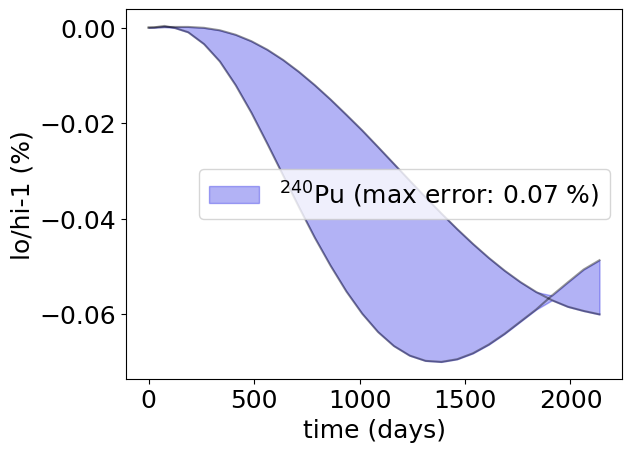

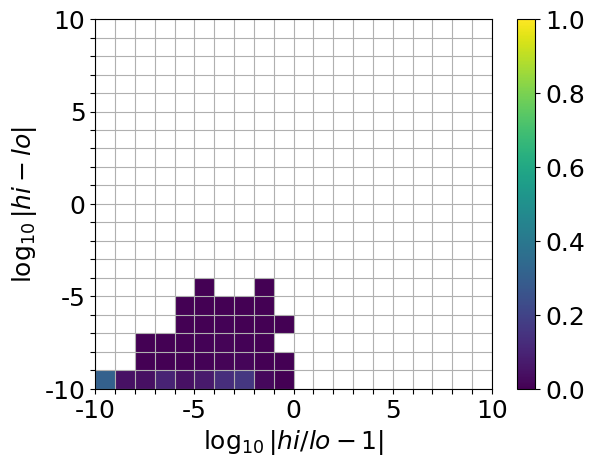

In [5]:
# Check for the original fine grid.
fine_time,fine_diff,fine_info = run_check('r01',0,rl)

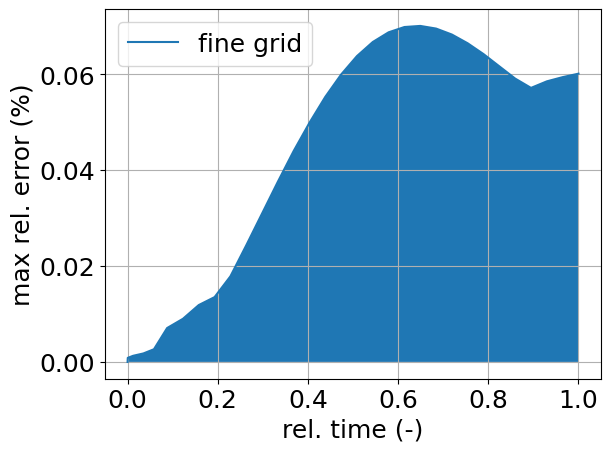

In [35]:
fine_error_metrics = get_error_metrics(fine_time,fine_diff)
plot_error_metrics( [fine_error_metrics],labels=['fine grid'] )

In [7]:
#strategy
#1. burnup - calculate ORIGAMI solution at each point in original fine grid
#2. keep only first and last burnups on the coarse grid
#3. using interpolation on the coarse grid, calculate the ORIGAMI solultion at each point in the original fine grid
#4. add back the point that reduces the error the most on the coarse grid
#5. repeat on #3 until error is reasonable

## Optimization Iteration 0

[ 2  1 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.22it/s]


[0, 31]
['w17x17_e0400w0723.h5', 'w17x17_e0850w0723.h5']
[4.0, 8.5]
[0.723, 0.723]
[0.0, 84000.0]


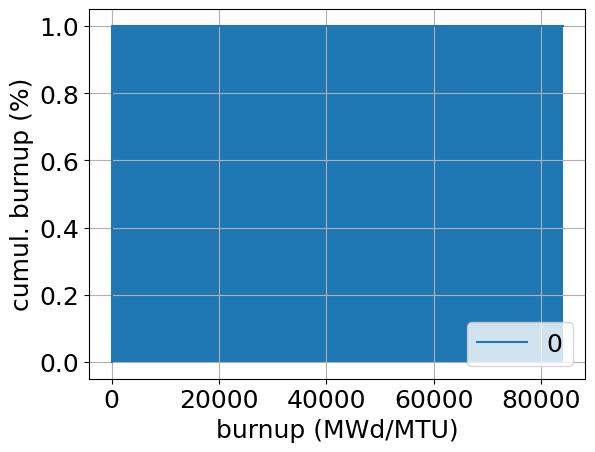

2024-10-31 09:13:55 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-31 09:13:55 [info     ] Running SCALE                  version=6.3.2
2024-10-31 09:13:55 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/r01_0 && make -j 8
2024-10-31 09:13:55 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-31 09:13:55 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-31 09:14:07 [info     ]                               
2024-10-31 09:14:07 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/r01_0/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-31 09:14:07 [info     ] Running exte

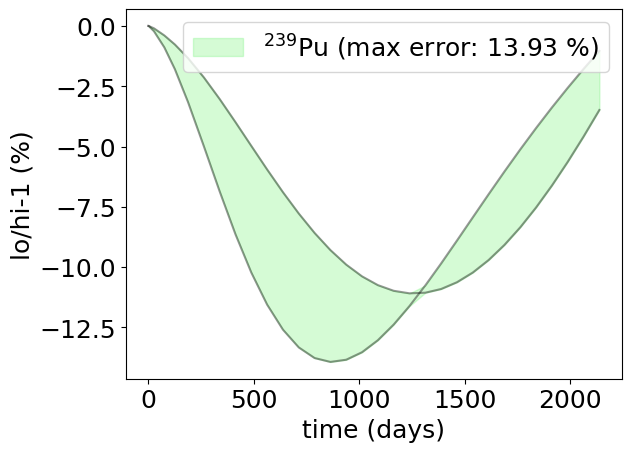

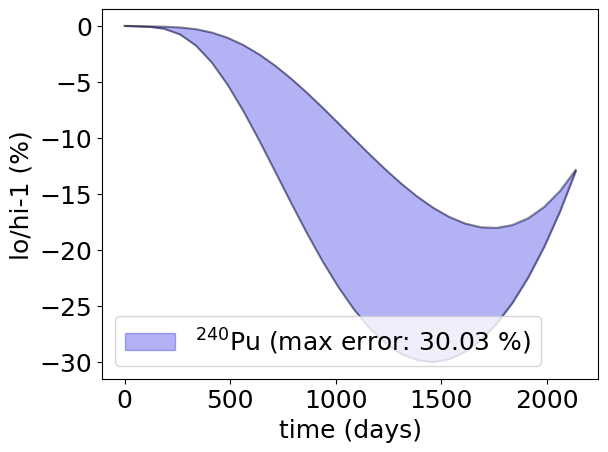

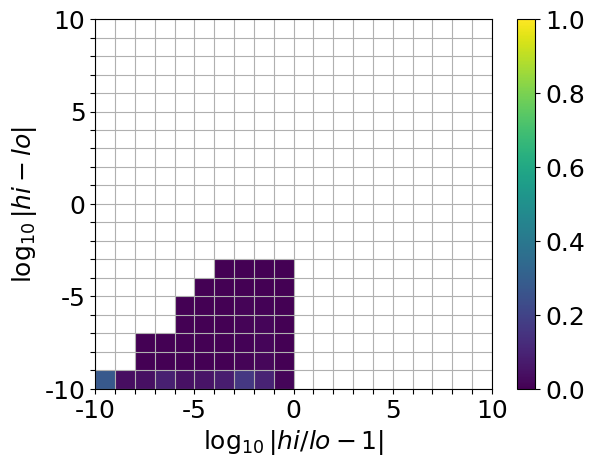

In [8]:
# Start optimization.
error_list = []
burnup_list = []
info_list = []

# Get the new reactor library with only endpoints.
requested_burnups = [fine_burnups[0],fine_burnups[-1]]
rl = reset_reactor_library(requested_burnups)

# We are doing nearest matching to requested burnups so always take the
# burnups from the OUTPUT of the reset.
burnup_list.append( rl.axes_values[-1] )
plot_burnup_grids( burnup_list )

# Run the checks.
time, diff, info = run_check('r01',0,rl)

# Save the information.
error_list.append( get_error_metrics(time,diff) )
info_list.append( info )

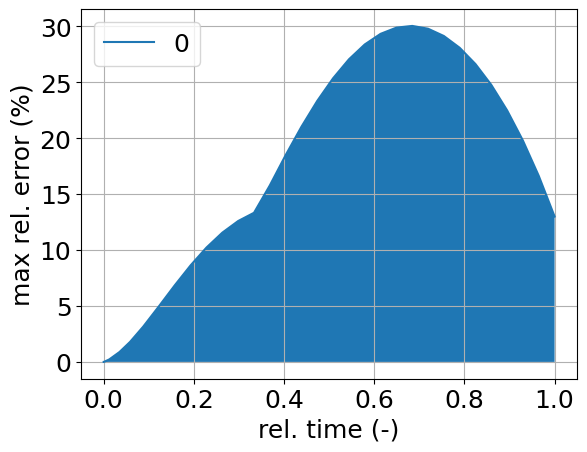

In [9]:
# Generate new error plots.
plot_error_metrics( error_list )

In [10]:
# This is where the maximum difference occurs in the solution time
# steps. These are different from where the xs are tabulated.
max_diff_reltime = error_list[-1]['max_diff_reltime']
max_diff_burnup = fine_burnups[-1]*max_diff_reltime
print('max_diff_burnup:',max_diff_burnup)

max_diff_burnup: 57473.68421052632


## Optimization Iteration 1

[ 2  1 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.37it/s]


[0, 22, 31]
['w17x17_e0400w0723.h5', 'w17x17_e0850w0723.h5']
[4.0, 8.5]
[0.723, 0.723]
[0.0, 57000.0, 84000.0]


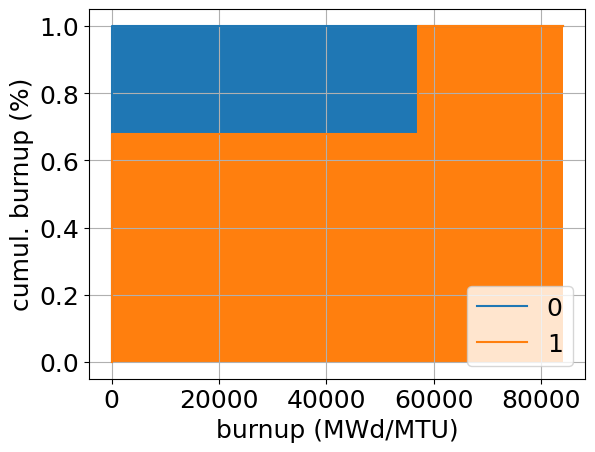

In [11]:
# Now we regenerate a new library with an additional point using the last list and adding one.
requested_burnups = list(burnup_list[-1])
requested_burnups.append( max_diff_burnup )

rl = reset_reactor_library(requested_burnups)
burnup_list.append( rl.axes_values[-1] )
plot_burnup_grids( burnup_list )

2024-10-31 09:14:08 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-31 09:14:08 [info     ] Running SCALE                  version=6.3.2
2024-10-31 09:14:08 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/r01_1 && make -j 8
2024-10-31 09:14:08 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-31 09:14:08 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-31 09:14:20 [info     ]                               
2024-10-31 09:14:20 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/r01_1/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-31 09:14:20 [info     ] Running exte

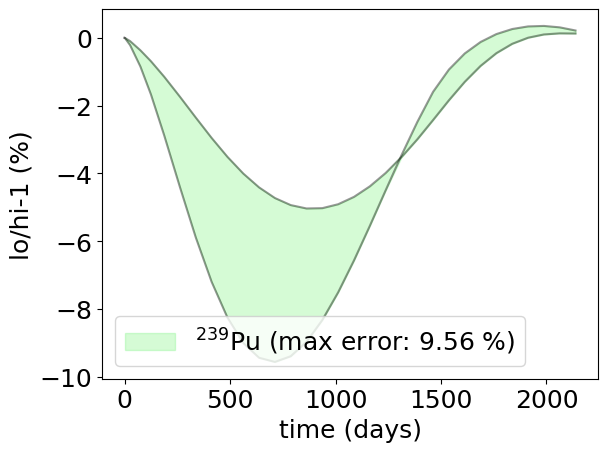

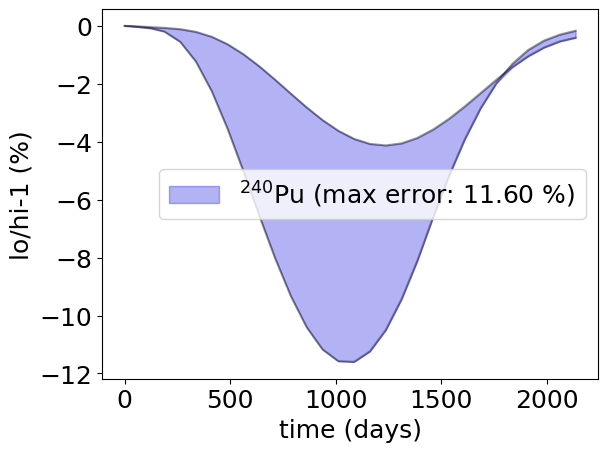

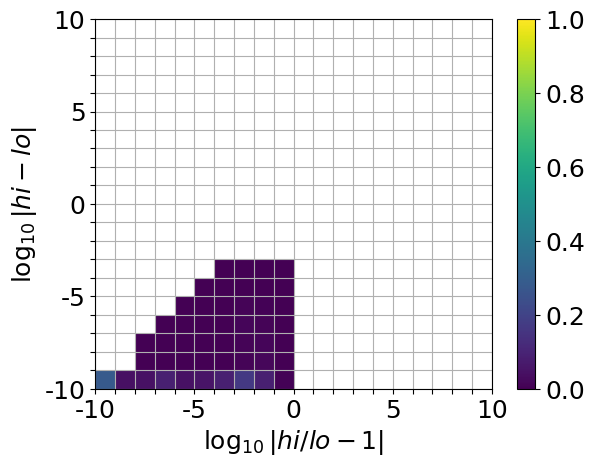

In [12]:
# Run the checks. Note we are called this sequence 1 now.
time, diff, info = run_check('r01',1,rl)

# Save the information.
error_list.append( get_error_metrics(time,diff) )
info_list.append( info )

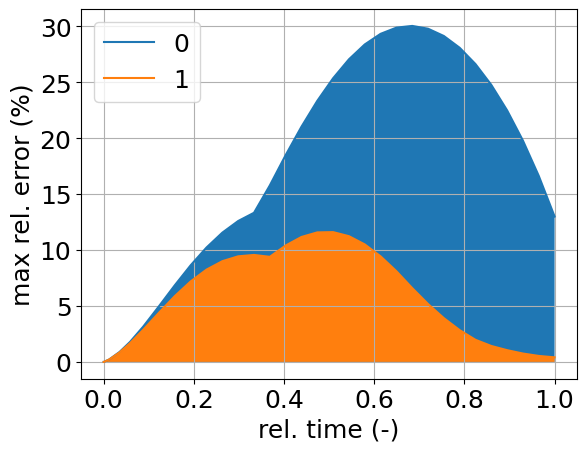

In [13]:
# Generate new error plots.
plot_error_metrics( error_list )

In [14]:
# This is where the maximum difference occurs in the solution time
# steps. These are different from where the xs are tabulated.
max_diff_reltime = error_list[-1]['max_diff_reltime']
max_diff_burnup = fine_burnups[-1]*max_diff_reltime
print('max_diff_burnup:',max_diff_burnup)

max_diff_burnup: 42736.84210526316


## Optimization Iteration 2

[ 2  1 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.48it/s]


[0, 17, 22, 31]
['w17x17_e0400w0723.h5', 'w17x17_e0850w0723.h5']
[4.0, 8.5]
[0.723, 0.723]
[0.0, 42000.0, 57000.0, 84000.0]


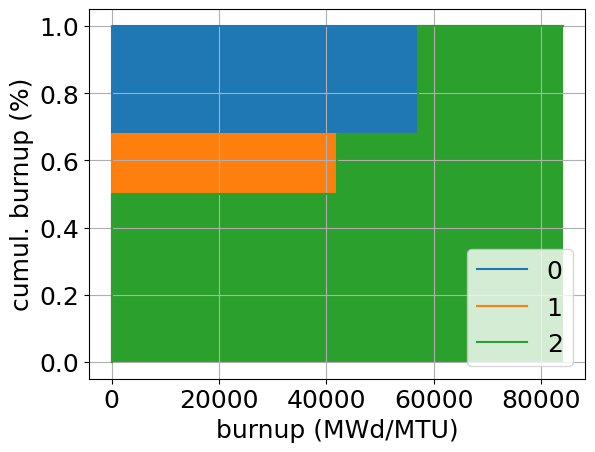

In [15]:
# Now we regenerate a new library with an additional point using the last list and adding one.
requested_burnups = list(burnup_list[-1])
requested_burnups.append( max_diff_burnup )

rl = reset_reactor_library(requested_burnups)
burnup_list.append( rl.axes_values[-1] )
plot_burnup_grids( burnup_list )

2024-10-31 09:14:22 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-31 09:14:22 [info     ] Running SCALE                  version=6.3.2
2024-10-31 09:14:22 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/r01_2 && make -j 8
2024-10-31 09:14:22 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-31 09:14:22 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-31 09:14:33 [info     ]                               
2024-10-31 09:14:33 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/r01_2/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-31 09:14:34 [info     ] Running exte

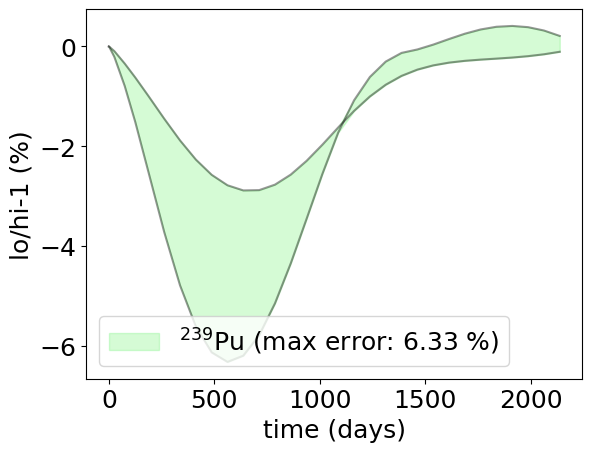

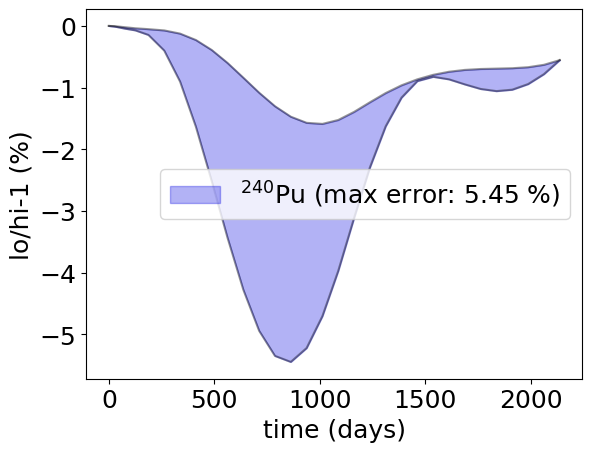

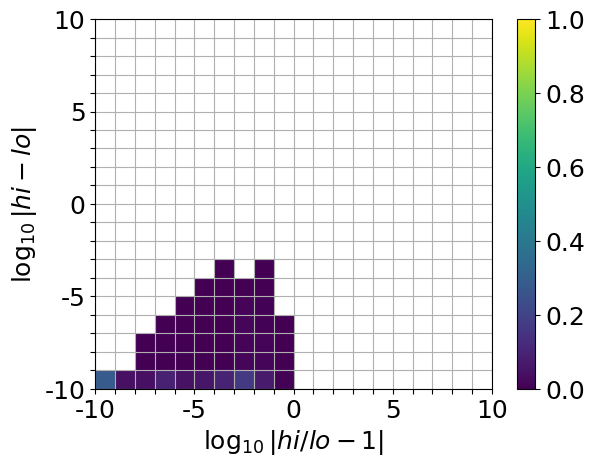

In [16]:
# Run the checks. Note we are called this sequence 2 now.
time, diff, info = run_check('r01',2,rl)

# Save the information.
error_list.append( get_error_metrics(time,diff) )
info_list.append( info )

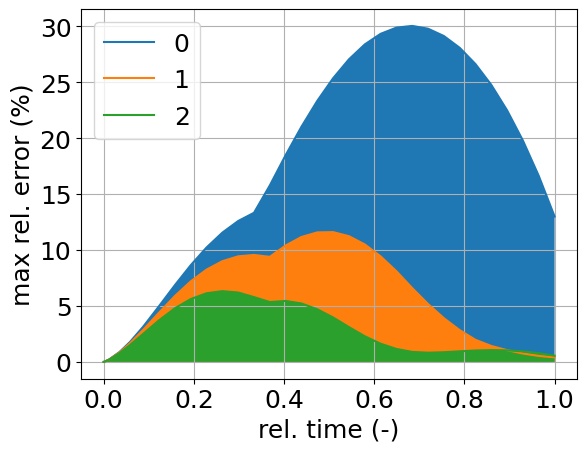

In [17]:
# Generate new error plots.
plot_error_metrics( error_list )

In [18]:
# This is where the maximum difference occurs in the solution time
# steps. These are different from where the xs are tabulated.
max_diff_reltime = error_list[-1]['max_diff_reltime']
max_diff_burnup = fine_burnups[-1]*max_diff_reltime
print('max_diff_burnup:',max_diff_burnup)

max_diff_burnup: 22105.263157894737


## Optimization Iteration 3

[ 2  1 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.46it/s]


[0, 10, 17, 22, 31]
['w17x17_e0400w0723.h5', 'w17x17_e0850w0723.h5']
[4.0, 8.5]
[0.723, 0.723]
[0.0, 21000.0, 42000.0, 57000.0, 84000.0]


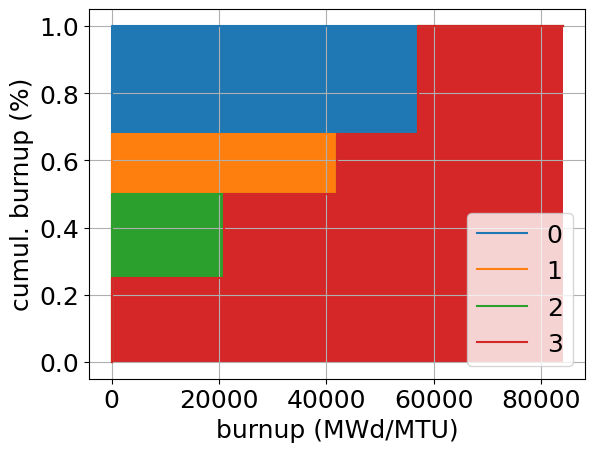

In [19]:
# Now we regenerate a new library with an additional point using the last list and adding one.
requested_burnups = list(burnup_list[-1])
requested_burnups.append( max_diff_burnup )

rl = reset_reactor_library(requested_burnups)
burnup_list.append( rl.axes_values[-1] )
plot_burnup_grids( burnup_list )

2024-10-31 09:14:35 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-31 09:14:35 [info     ] Running SCALE                  version=6.3.2
2024-10-31 09:14:35 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/r01_3 && make -j 8
2024-10-31 09:14:35 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-31 09:14:35 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-31 09:14:47 [info     ]                               
2024-10-31 09:14:47 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/r01_3/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-31 09:14:47 [info     ] Running exte

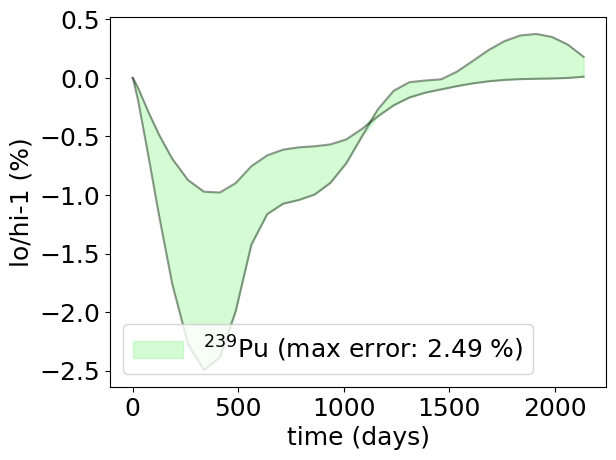

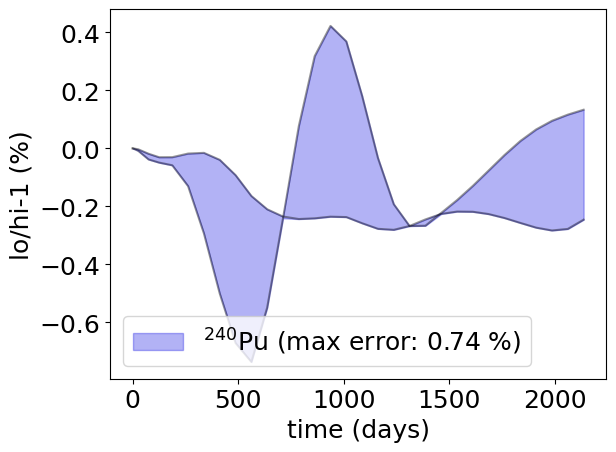

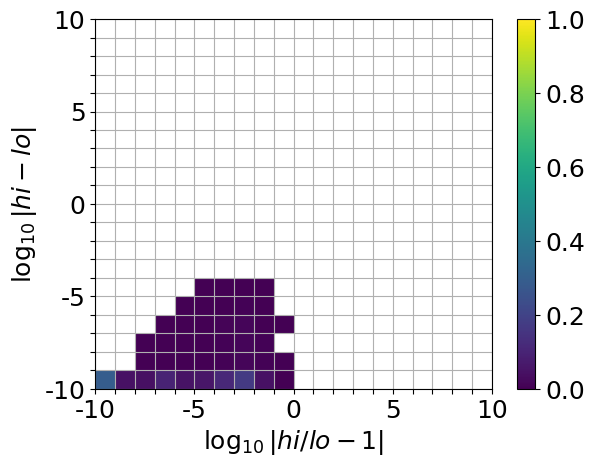

In [20]:
# Run the checks. Note we are called this sequence 3 now.
time, diff, info = run_check('r01',3,rl)

# Save the information.
error_list.append( get_error_metrics(time,diff) )
info_list.append( info )

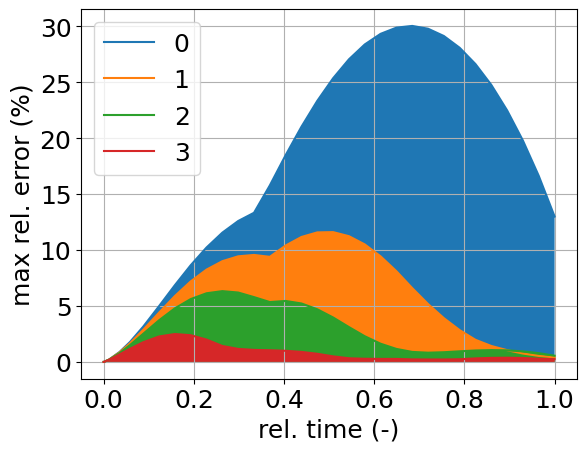

In [21]:
# Generate new error plots.
plot_error_metrics( error_list )

In [22]:
# This is where the maximum difference occurs in the solution time
# steps. These are different from where the xs are tabulated.
max_diff_reltime = error_list[-1]['max_diff_reltime']
max_diff_burnup = fine_burnups[-1]*max_diff_reltime
print('max_diff_burnup:',max_diff_burnup)

max_diff_burnup: 13263.157894736842


## Optimization Iteration 4

[ 2  1 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.24it/s]


[0, 7, 10, 17, 22, 31]
['w17x17_e0400w0723.h5', 'w17x17_e0850w0723.h5']
[4.0, 8.5]
[0.723, 0.723]
[0.0, 12000.0, 21000.0, 42000.0, 57000.0, 84000.0]


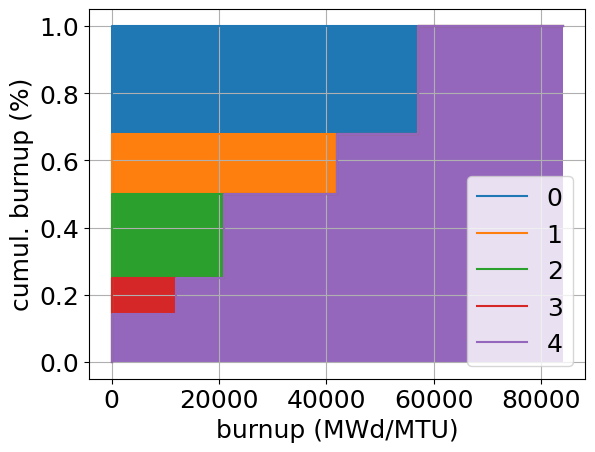

In [23]:
# Now we regenerate a new library with an additional point using the last list and adding one.
requested_burnups = list(burnup_list[-1])
requested_burnups.append( max_diff_burnup )

rl = reset_reactor_library(requested_burnups)
burnup_list.append( rl.axes_values[-1] )
plot_burnup_grids( burnup_list )

2024-10-31 09:14:48 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-31 09:14:49 [info     ] Running SCALE                  version=6.3.2
2024-10-31 09:14:49 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/r01_3 && make -j 8
2024-10-31 09:14:49 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-31 09:14:49 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-31 09:15:00 [info     ]                               
2024-10-31 09:15:00 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/r01_3/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-31 09:15:00 [info     ] Running exte

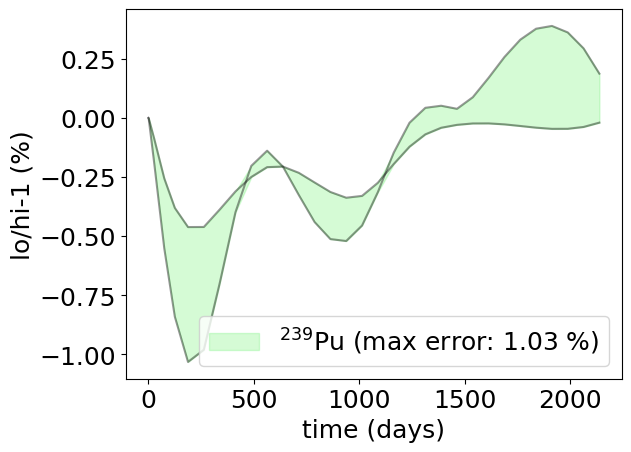

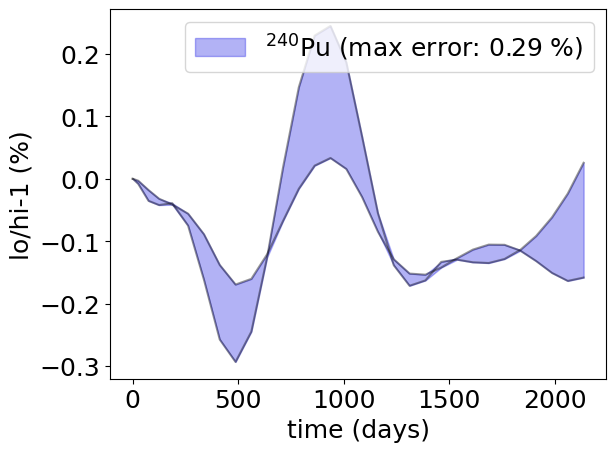

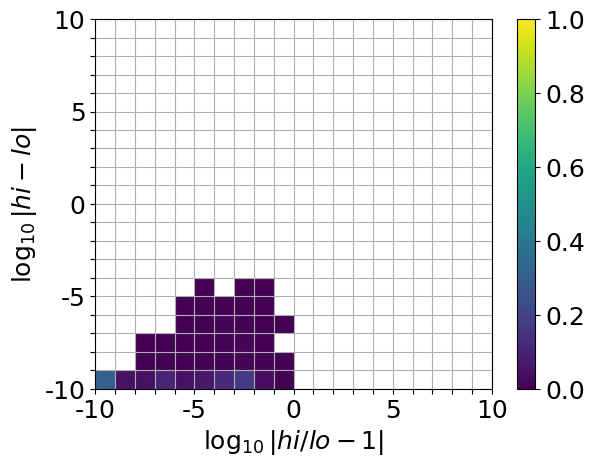

In [24]:
# Run the checks. Note we are called this sequence 3 now.
time, diff, info = run_check('r01',3,rl)

# Save the information.
error_list.append( get_error_metrics(time,diff) )
info_list.append( info )

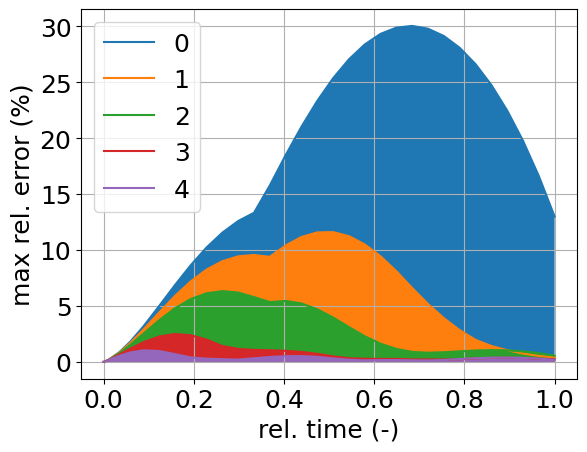

In [25]:
# Generate new error plots.
plot_error_metrics( error_list )

In [26]:
# This is where the maximum difference occurs in the solution time
# steps. These are different from where the xs are tabulated.
max_diff_reltime = error_list[-1]['max_diff_reltime']
max_diff_burnup = fine_burnups[-1]*max_diff_reltime
print('max_diff_burnup:',max_diff_burnup)

max_diff_burnup: 7368.421052631578


## Finished

Optimized grid burnups: 0.00e+00,1.20e+04,2.10e+04,4.20e+04,5.70e+04,8.40e+04


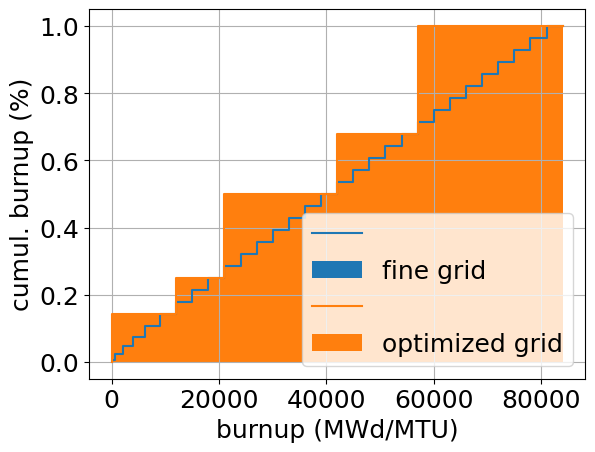

In [38]:
print('Optimized grid burnups:', ','.join(['{:.2e}'.format(b) for b in burnup_list[-1]]))
plot_burnup_grids( [fine_burnups,burnup_list[-1]],labels=['', 'fine grid', '', 'optimized grid'] )